Mini Project 02 [Ohid Reza 2212087642 | Group T]

In [83]:
#libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#ml libraries
from scipy.stats import skew, kurtosis, zscore
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from imblearn.over_sampling import SMOTE

In [84]:
data = pd.read_csv("data.csv")
data.head()

,p_id,accuracy,avg_reac_time
0,p01,97.9,188
1,p02,89.8,365
2,p03,98.9,205
3,p04,98.1,174
4,p05,97.8,134


Manual Labeling

In [85]:
#[logic]
#label: 1 if accuracy >= 95 and avg_reac_time <= 200, else 0
data['manual_label'] = data.apply(
    lambda row: 1 if row['accuracy'] >= 95 and row['avg_reac_time'] <= 200 else 0,
    axis=1
)
data.head()

,p_id,accuracy,avg_reac_time,manual_label
0,p01,97.9,188,1
1,p02,89.8,365,0
2,p03,98.9,205,0
3,p04,98.1,174,1
4,p05,97.8,134,1


In [86]:
#label distribution
print("Label Distribution:")
print(data['manual_label'].value_counts())

Label Distribution:
manual_label
0    17
1    13
Name: count, dtype: int64


Statistical Features

In [87]:
#summary
print(data.describe())

#skewness and kurtosis
print("\nSkewness of Accuracy:", skew(data['accuracy']))
print("Skewness of Reaction Time:", skew(data['avg_reac_time']))
print("\nKurtosis of Accuracy:", kurtosis(data['accuracy']))
print("Kurtosis of Reaction Time:", kurtosis(data['avg_reac_time']))


         accuracy  avg_reac_time  manual_label
count   30.000000      30.000000     30.000000
mean    95.093333     269.666667      0.433333
std      4.289838     158.005092      0.504007
min     85.600000      95.000000      0.000000
25%     92.075000     152.750000      0.000000
50%     97.000000     203.000000      0.000000
75%     98.075000     365.000000      1.000000
max    100.000000     623.000000      1.000000

Skewness of Accuracy: -0.8250814630221777
Skewness of Reaction Time: 0.9324781740881183

Kurtosis of Accuracy: -0.5644592048391925
Kurtosis of Reaction Time: -0.44653266112916823


In [ ]:
#z scores
data['accuracy_zscore'] = zscore(data['accuracy'])
data['reac_time_zscore'] = zscore(data['avg_reac_time'])

#normalization
scaler_norm = MinMaxScaler()
data[['accuracy_normalized', 'avg_reac_time_normalized']] = scaler_norm.fit_transform(
    data[['accuracy', 'avg_reac_time']]
)

#performance ratio
data['performance_ratio'] = data['accuracy'] / data['avg_reac_time']

#entropy of accuracy
epsilon = 1e-10
prob_accuracy = data['accuracy_normalized'] / data['accuracy_normalized'].sum()
data['accuracy_entropy'] = -prob_accuracy * np.log2(prob_accuracy + epsilon)
print("Total Accuracy Entropy:", data['accuracy_entropy'].sum())

#scaling
scaler_std = StandardScaler()
data[['accuracy_scaled', 'avg_reac_time_scaled']] = scaler_std.fit_transform(
    data[['accuracy', 'avg_reac_time']]
)

data.head()

Total Accuracy Entropy: 4.716448122497269


,p_id,accuracy,avg_reac_time,manual_label,accuracy_zscore,reac_time_zscore,accuracy_normalized,avg_reac_time_normalized,performance_ratio,accuracy_entropy,accuracy_scaled,avg_reac_time_scaled
0,p01,97.9,188,1,0.665444,-0.525697,0.854167,0.176136,0.520745,0.195782,0.665444,-0.525697
1,p02,89.8,365,0,-1.255018,0.613671,0.291667,0.511364,0.246027,0.089713,-1.255018,0.613671
2,p03,98.9,205,0,0.902538,-0.416266,0.923611,0.208333,0.482439,0.206433,0.902538,-0.416266
3,p04,98.1,174,1,0.712863,-0.615816,0.868056,0.149621,0.563793,0.197944,0.712863,-0.615816
4,p05,97.8,134,1,0.641735,-0.873300,0.847222,0.073864,0.729851,0.194694,0.641735,-0.873300


Data Visualization

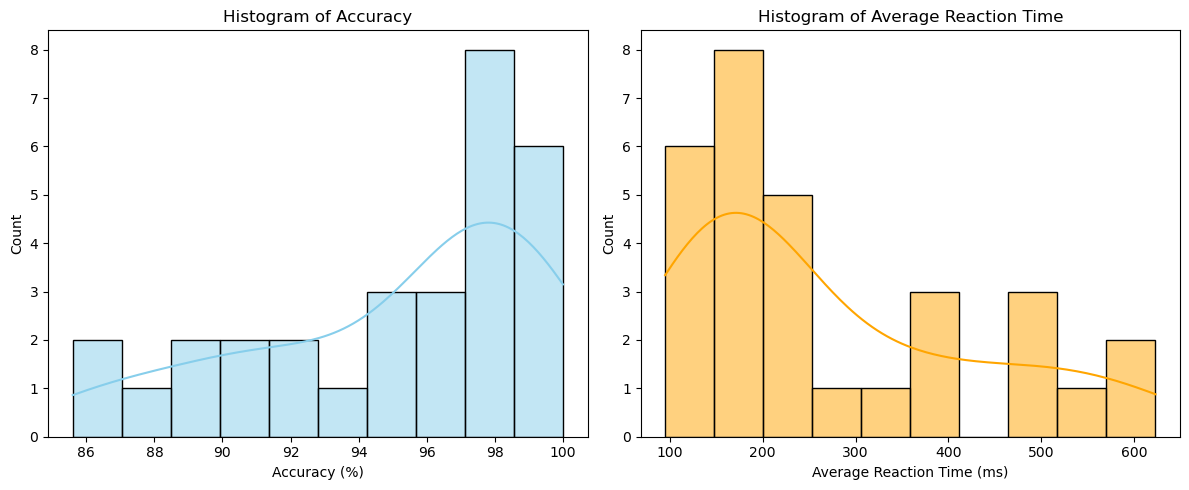

In [89]:
#histograms of accuracy and avg reac time
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(data['accuracy'], bins=10, kde=True, color='skyblue')
plt.title("Histogram of Accuracy")
plt.xlabel("Accuracy (%)")

plt.subplot(1, 2, 2)
sns.histplot(data['avg_reac_time'], bins=10, kde=True, color='orange')
plt.title("Histogram of Average Reaction Time")
plt.xlabel("Average Reaction Time (ms)")

plt.tight_layout()
plt.savefig("dv_histo.png")
plt.show()


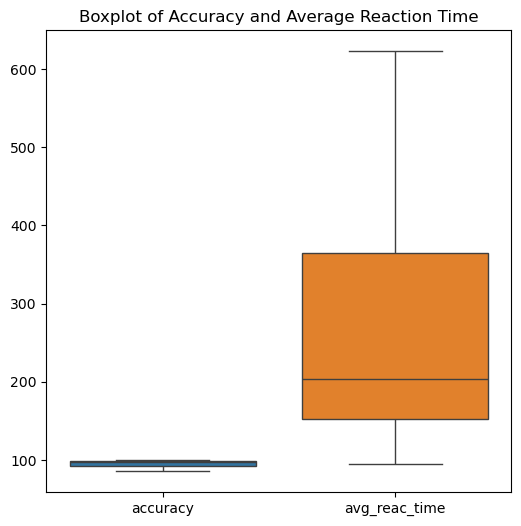

In [90]:
#boxplot of accuracy and avg reac time
plt.figure(figsize=(6, 6))
sns.boxplot(data=data[['accuracy', 'avg_reac_time']])
plt.title("Boxplot of Accuracy and Average Reaction Time")
plt.savefig("dv_boxplot.png")
plt.show()

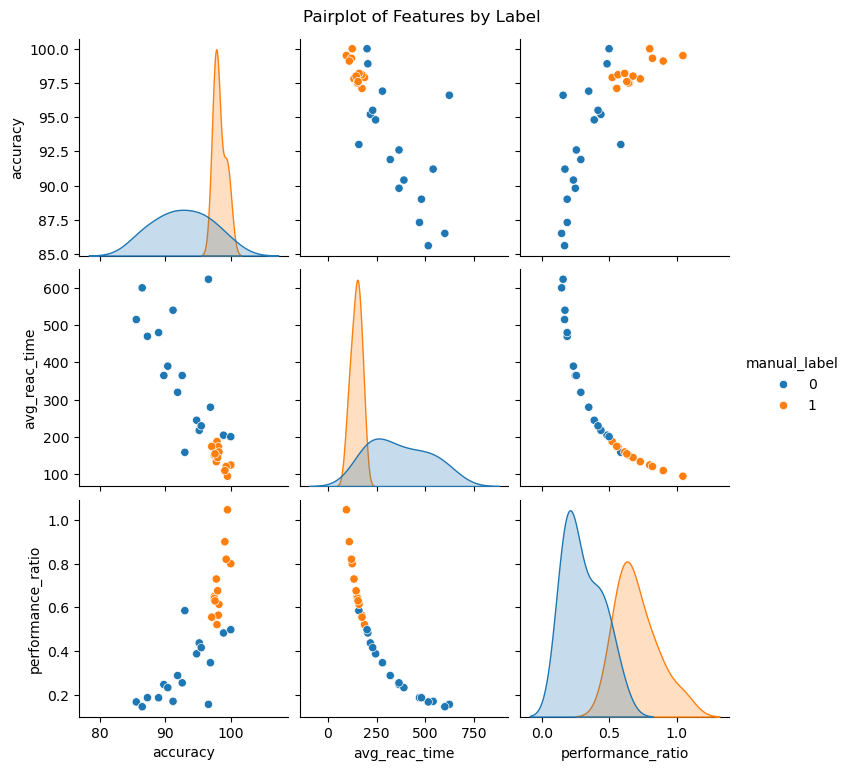

In [ ]:
#pairplot of features by label
sns.pairplot(data[['accuracy', 'avg_reac_time', 'performance_ratio', 'manual_label']], hue='manual_label')
plt.suptitle("Pairplot of Features by Label", y=1.02)
plt.savefig("dv_pairplot.png")
plt.show()

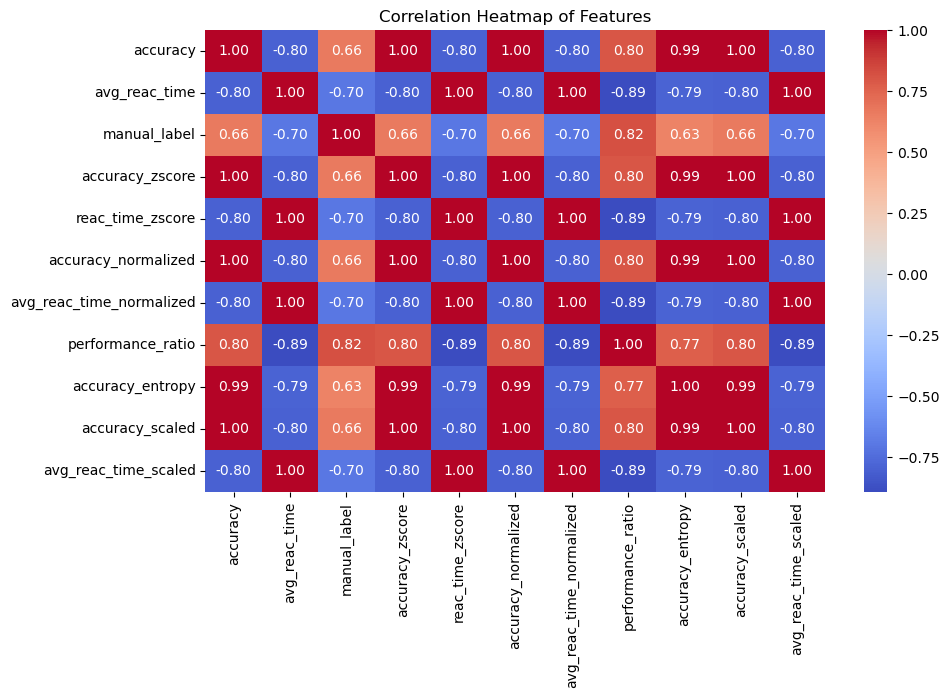

In [ ]:
#features correlation heatmap
numeric_data = data.select_dtypes(include=[float, int])

plt.figure(figsize=(10, 6))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Features")
plt.savefig("dv_heatmap.png")
plt.show()

Train Test Split and Imbalance Handaling

In [93]:
X_raw = data[['accuracy', 'avg_reac_time', 'performance_ratio']]
X_scaled = data[['accuracy_scaled', 'avg_reac_time_scaled', 'accuracy_zscore', 'reac_time_zscore', 'performance_ratio']]
y = data['manual_label']

X_train_raw, X_test_raw, y_train_raw, y_test = train_test_split(X_raw, y, test_size=0.3, random_state=42)
X_train_scaled, X_test_scaled, y_train_scaled, _ = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

#imbalance handaling with smote
sm = SMOTE(random_state=42)
X_train_raw, y_train_raw = sm.fit_resample(X_train_raw, y_train_raw)
X_train_scaled, y_train_scaled = sm.fit_resample(X_train_scaled, y_train_scaled)

Neural Network

In [94]:
param_grid_nn = {
    'hidden_layer_sizes': [(10,), (20,), (10, 10)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001]
}

grid_nn = GridSearchCV(MLPClassifier(max_iter=1500, random_state=42), param_grid_nn, cv=3)
grid_nn.fit(X_train_scaled, y_train_scaled)
print("Best NN Parameters:", grid_nn.best_params_)

y_p_nn = grid_nn.predict(X_test_scaled)

Best NN Parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (20,)}


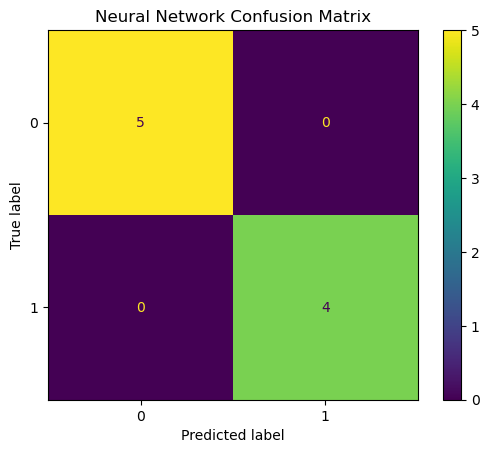

In [95]:
cm_nn = confusion_matrix(y_test, y_p_nn)
ConfusionMatrixDisplay(cm_nn).plot()
plt.title("Neural Network Confusion Matrix")
plt.savefig("nn_confusion_matrix.png")
plt.show()

In [96]:
print(classification_report(y_test, y_p_nn))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         4

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9



Random Forest

In [97]:
param_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_rf, cv=3)
grid_rf.fit(X_train_raw, y_train_raw)
print("Best RF Parameters:", grid_rf.best_params_)

y_p_rf = grid_rf.predict(X_test_raw)


Best RF Parameters: {'max_depth': None, 'n_estimators': 50}


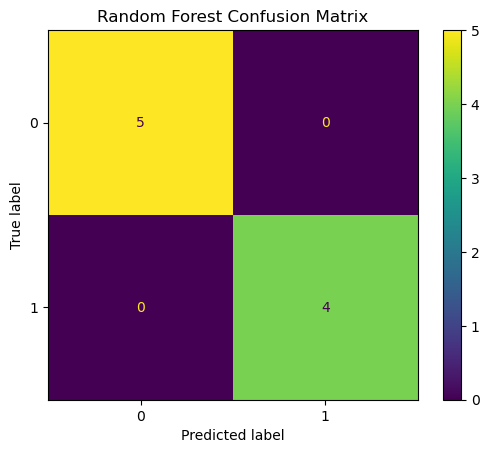

In [98]:
cm_rf = confusion_matrix(y_test, y_p_rf)
ConfusionMatrixDisplay(cm_rf).plot()
plt.title("Random Forest Confusion Matrix")
plt.savefig("rf_confusion_matrix.png")
plt.show()

In [99]:
print(classification_report(y_test, y_p_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         4

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9



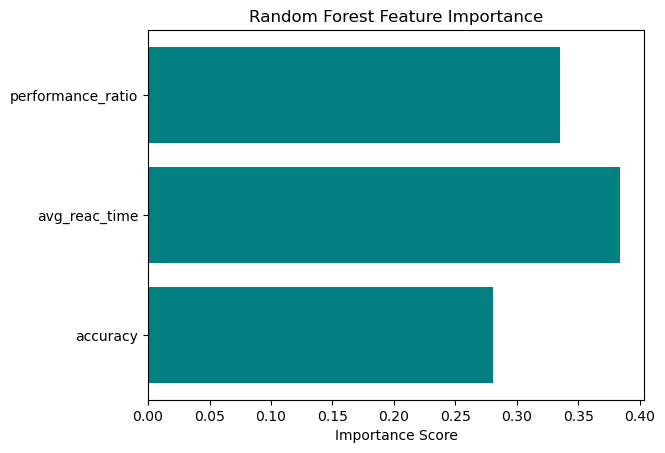

In [100]:
importances_rf = grid_rf.best_estimator_.feature_importances_
plt.barh(X_raw.columns, importances_rf, color='teal')
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance Score")
plt.show()

XGBoost

In [101]:
param_xgb = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_xgb = GridSearchCV(XGBClassifier(eval_metric='logloss', random_state=42), param_xgb, cv=3)
grid_xgb.fit(X_train_raw, y_train_raw)
print("Best XGB Parameters:", grid_xgb.best_params_)

y_p_xgb = grid_xgb.predict(X_test_raw)

Best XGB Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


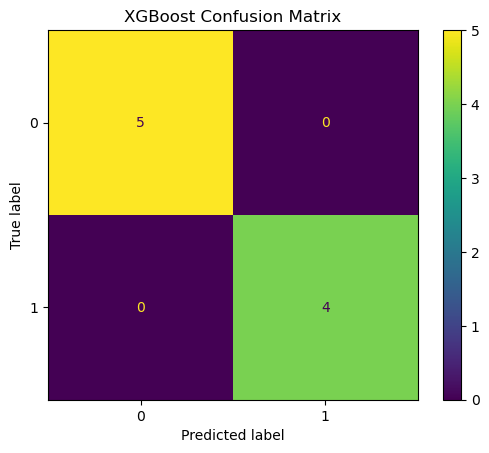

In [102]:
cm_xgb = confusion_matrix(y_test, y_p_xgb)
ConfusionMatrixDisplay(cm_xgb).plot()
plt.title("XGBoost Confusion Matrix")
plt.savefig("xgb_confusion_matrix.png")
plt.show()

In [103]:

print(classification_report(y_test, y_p_xgb))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         4

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9



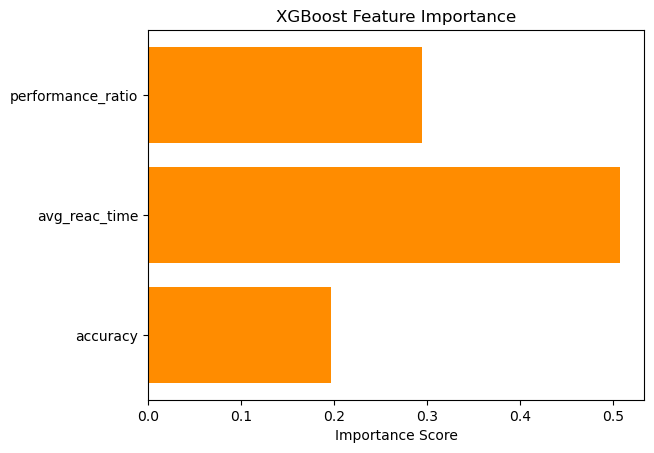

In [104]:
importances_xgb = grid_xgb.best_estimator_.feature_importances_
plt.barh(X_raw.columns, importances_xgb, color='darkorange')
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance Score")
plt.show()

Final Data

In [105]:
data.to_csv("data_final.csv", index=False)
print("saved as data_final.csv")

saved as data_final.csv
